ImportError: cannot import name 'mendelSim' from 'helperss' (C:\Users\JWant\Documents\CLS\Stochastic Simulation\stochsim_assignment1\helperss.py)

In [9]:
from PIL import Image
import colorsys
import math
import os
import numpy as np
import matplotlib.pyplot as plt

class mendelSim():
    def __init__(self, width = 1000, x =-0.65, y = 0, xRange = 3.4, aspectRatio = 4/3, 
                 simStrat = "random", draw = True, niceColors = True,
                 num_points = 30000, precision = 200):
        self.draw = draw
        self.niceColors = niceColors
        self.simStrat = simStrat
        
        
        #frame parameters
        self.width = width #pixels
        self.x = x
        self.y = y
        self.xRange = xRange
        self.aspectRatio = aspectRatio 

        self.height = round(self.width / self.aspectRatio)
        self.yRange = self.xRange / self.aspectRatio
        self.minX = self.x - self.xRange / 2
        self.maxX = self.x + self.xRange / 2
        self.minY = self.y - self.yRange / 2
        self.maxY = self.y + self.yRange / 2
        
        self.num_points = num_points
        self.precision = precision
    
    
    def run_sim(self):
        if self.draw: 
            self.drawPicture()
                        
        # run monte carlo simulation
        inCount = 0
        if self.simStrat == "random":
            coordinates = self.getCoordinates()
        elif self.simStrat == "latin":
            assert self.height == self.width
            coordinates = self.getLatinCube()
        elif self.simStrat == "orthogonal":
            #TODO
            pass
        else:
            raise ValueError
        for c in range(len(coordinates[0])):
            x = self.minX + coordinates[0][c] * self.xRange / self.width
            y = self.maxY - coordinates[1][c] * self.yRange / self.height
            oldX = x
            oldY = y
            for i in range(self.precision + 1):
                a = x*x - y*y #real component of z^2
                b = 2 * x * y #imaginary component of z^2
                x = a + oldX #real component of new z
                y = b + oldY #imaginary component of new z
                if x*x + y*y > 4:
                    break
            if i == self.precision:
                inCount += 1
            if self.draw: 
                rgb = self.redBlue(i, 0.2, 0.27, 1.0)
                self.pixels[coordinates[0][c],coordinates[1][c]] = rgb


        if self.draw: 
            self.img.save('output.png')

        areaPicture = self.xRange * self.yRange
        percentageMendel = inCount/self.num_points
        areaMendel = areaPicture * percentageMendel
        
        
        print(f"incount: {inCount}")
        print(f"areapic: {areaPicture}")
        print(f"percentin: {percentageMendel}")
        print(f"areain: {areaMendel}")
        return areaMendel
    
    
    def drawPicture(self):
        # draw mandelbrot image
        self.img = Image.new('RGB', (self.width, self.height), color = 'white')
        self.pixels = self.img.load()

        for row in range(self.height):
            for col in range(self.width):
                x = self.minX + col * self.xRange / self.width
                y = self.maxY - row * self.yRange / self.height
                oldX = x
                oldY = y
                for i in range(self.precision + 1):
                    a = x*x - y*y #real component of z^2
                    b = 2 * x * y #imaginary component of z^2
                    x = a + oldX #real component of new z
                    y = b + oldY #imaginary component of new z
                    if x*x + y*y > 4:
                        break
                if i < self.precision:
                    rgb = (0,0,0)
                    if self.niceColors:
                        distance = (i + 1) / (self.precision + 1)
                        rgb = self.powerColor(distance, 0.2, 0.27, 1.0)
                    self.pixels[col,row] = rgb
        
                    
    def getCoordinates(self):
        x = []
        y = []
        for i in range(self.num_points):
            x.append(np.random.random())
            y.append(np.random.random())
        return ([i*self.width for i in x], [i*self.height for i in y])
    
    
    def getLatinCube(self):
        x = []
        y = []
        possibilities = np.arange(self.width)
        np.random.shuffle(possibilities)
        for row in range(self.width):
            x.append(row)
            y.append(possibilities[row])

        return (x, y)
    
    
    def logColor(self, distance, base, const, scale):
        color = -1 * math.log(distance, base)
        rgb = colorsys.hsv_to_rgb(const + scale * color,0.8,0.9)
        return tuple(round(i * 255) for i in rgb)

    
    def powerColor(self, distance, exp, const, scale):
        color = distance**exp
        rgb = colorsys.hsv_to_rgb(const + scale * color,1 - 0.6 * color,0.9)
        return tuple(round(i * 255) for i in rgb)

    
    def redBlue(self, distance, exp, const, scale):
        if distance == self.precision:
            rgb = (0,255,0)
        else:
            rgb = (255,0,0)
        return rgb

In [10]:
# plot a pretty picture in the current directory called "output.png"
simulator = mendelSim(precision = 50, num_points=100000)
simulator.run_sim()

incount: 18462
areapic: 8.67
percentin: 0.18462
areain: 1.6006554


1.6006554

In [291]:
# parallelize to speed up
from joblib import Parallel, delayed
from tqdm import notebook

def monteCarlo(precision, num_points, simStrat):
    # no plot simulator
    simulator = mendelSim(precision=precision, num_points=num_points, simStrat = simStrat, draw=False, niceColors=False)
    return simulator.run_sim()

In [293]:
# try to get a good estimate of the influence of num_points (s) and precision(i)
# alter amount of jobs to fit your system
# results for precision
# shuffle the input to enhance time estimate
inputPrecision = np.arange(1000)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = i, num_points = 30000)
                                      for i in notebook.tqdm(inputPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [202]:
# results for number of points
inputPoints = np.arange(60000)
np.random.shuffle(inputPoints)
resultsPoints = Parallel(n_jobs=8)(delayed(monteCarlo)(precision = 100, num_points = i+1) for i in notebook.tqdm(inputPoints))

  0%|          | 0/60000 [00:00<?, ?it/s]

In [296]:
# investigate the convergence of the two parameters
# convert to np array to enhance speed

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == 999)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))


arrPoints = np.array(resultsPoints)
errorPoints = abs(arrPoints - arrPoints[np.where(inputPoints == 59999)[0]])
pointResult = np.array((inputPoints, arrPoints, errorPoints))


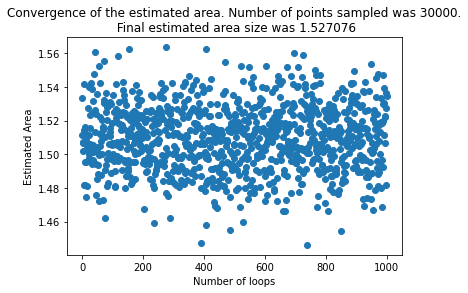

In [300]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was 30000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionArea.jpg")

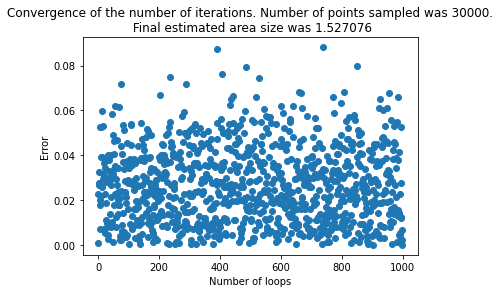

In [299]:
plt.scatter(precisionResult[0], precisionResult[2])
plt.ylabel("Error")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the number of iterations. Number of points sampled was 30000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionConvergence.jpg")

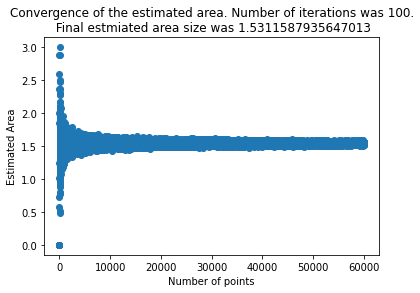

In [212]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 100.\n Final estmiated area size was {arrPoints[-1]}")
plt.savefig("pointsArea.jpg")

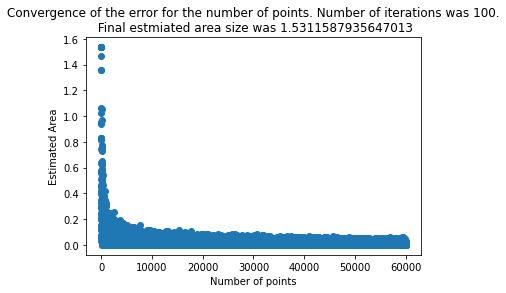

In [213]:
plt.scatter(pointResult[0], pointResult[2])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the error for the number of points. Number of iterations was 100.\n Final estmiated area size was {arrPoints[-1]}")
plt.savefig("pointsArea.jpg")

In [12]:
simulator = mendelSim(simStrat = "latin", width = 1000, aspectRatio = 1)
simulator.run_sim()

incount: 141
areapic: 11.559999999999999
percentin: 0.0047
areain: 0.054332


0.054332